In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
outlier_czs = [34105, 34113, 34112, 34106]
df = (
    pd.read_csv('data/mobility.csv')
    # filter out rows with NaN AUM values
    .query('not aum.isnull()', engine='python')
    # take out outlier CZs
    .query('cz not in @outlier_czs')
)

predictors = [
    'frac_traveltime_lt15',
    'gini',
    'dropout_r',
    'rel_tot',
    'cs_fam_wkidsinglemom',
    'taxrate',
    'gradrate_r',
    'frac_worked1416',
    'cs_born_foreign',
]

X = (df[predictors]
    # Some predictors are missing; we'll drop them for simplicity
    .dropna()
    .assign(intr=1)
    # Move intercept column to appear first
    [['intr', *predictors]]
)
y = df.loc[X.index, 'aum']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

(sec:linear_multi_fit)=
# Fitting the Multiple Linear Model

For a $ n \times (p + 1) $ design matrix $ X $, a $ n $-dimensional
column vector of outcomes $ y $, and a $ (p + 1) $-dimensional column 
vector of model parameters $ \theta $, we assume that:

$$
\begin{aligned}
y = X \theta + \epsilon
\end{aligned}
$$

Here, $ \epsilon $ is a $ n $-dimensional column vector that represents the
sampling error.
We define the multiple linear model as:

$$
\begin{aligned}
f_{\theta}(X) = X \theta
\end{aligned}
$$

Similar to the simple linear model, we'll fit $ f_{\theta}(X) $ using
the squared loss function.
We want to find the model parameters $ \hat{\theta} $ that minimize the
mean squared loss:

$$
\begin{aligned}
L(\theta, X, y)
 &= \frac{1}{n} \left | y - f_{\theta}(X) \right|^2
\end{aligned}
$$

Here, we're using the notation $ |v|^2 $ for a vector $ v $ as a
shorthand for the sum of each vector element squared [^l2]:
$ |v|^2 = \sum_i v_i^2 $ .

[^l2]: $ |v| $ is also called the $ \ell_2 $ norm of a
vector $ v $.

In this section, we'll fit our model by figuring out what the
minimizing $ \hat{\theta} $ is.
One idea is to use calculus as we did for the simple linear model.
However, this approach needs knowledge of vector calculus that we won't
cover in this book.
Instead, we'll use a geometric argument.

## A Geometric Problem

Our goal is the find the $ \hat{\theta} $ that minimizes our loss
function---we want to make $ L(\theta, X, y) $ as small as possible
for a given $ X $ and $ y $.
The key insight is that we can restate this goal in a geometric way.
Remember: the model predictions $ f_{\theta}(X) $ and the true outcomes
$ y $ are both vectors.
We can treat vectors as points---for example, we can plot
the vector $ [ 2, 3 ] $ at $ x = 2, y = 3 $ in 2D space.
Then, minimizing $ L(\theta, X, y) $ is equivalent to finding
$ \hat{\theta} $ that makes $ f_{\theta}(X) $ as close as possible to
$ y $ when we plot them as points.
As depicted in {numref}`Figure %s <fig:geom-2d>`, different values of
$ \theta $ give different predictions $ f_{\theta}(X) $ (hollow points).
Then, $ \hat{\theta} $ is the vector of parameters that put
$ f_{\theta}(X) $ as close to $ y $ (filled point) as possible.

```{figure} figures/geom-2d.svg
---
name: fig:geom-2d
width: 250px
---

A plot showing different values of $ f_{\theta}(X) $ (hollow points) and
the outcome vector $ y $ (filled point).
```

Next, we'll look at the possible values of $ f_{\theta}(X) $.
In {numref}`Figure %s <fig:geom-2d>`, we showed a few possible 
$ f_{\theta}(X) $.
Instead of just plotting a few possible points, we can
plot *all* possible values of $ f_{\theta}(X) $ by varying $ \theta $.
This results in a subspace of possible $ f_{\theta}(X) $ values, as shown in
{numref}`Figure %s <fig:geom-span>`.

```{figure} figures/geom-span.svg
---
name: fig:geom-span
width: 250px
---

A plot showing all possible values of $ f_{\theta}(X) $ as a line.
```

In the above {numref}`Figure %s <fig:geom-span>`, we drew the set of
possible $ f_{\theta}(X) $ values as a line.
Since our model is $ f_{\theta}(X) = X \theta $, from a property of
matrix-vector multiplication we know that $ f_{\theta}(X) $ is a linear
combination of the columns of $ X $, which we also call $ \text{span}(X) $.
Now, we need to figure out which point within $ \text{span}(X) $ lies the
closest to $ y $.

As {numref}`Figure %s <fig:geom-span>` suggests, the closest point to $ y $ 
is the point where the error $ \epsilon = y - f_{\theta}(X) $ is perpendicular
to $ \text{span}(X) $. We'll leave the complete proof as an exercise.
With this final fact, we can solve for $ \hat{\theta} $:

$$
\begin{aligned}
f_\hat{\theta}(X) + \epsilon &= y \\
X \hat{\theta} + \epsilon &= y \\
X^\top X \hat{\theta} + X^\top \epsilon &= X^\top y
    & (\text{left-multiply both sides by } X^\top) \\
X^\top X \hat{\theta} &= X^\top y
    & (X^\top \epsilon = 0 \text{ since } \epsilon \perp \text{span}(X)) \\
\hat{\theta} &= (X^\top X)^{-1} X^\top y
\end{aligned}
$$


With this derivation done, we can now write a short function to
fit the multiple linear model using $ X $ and $ y $.

In [3]:
def fit(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

Notice that deriving $ \hat{\theta} $ for the multiple linear model also gives
us $ \hat{\theta} $ for the simple linear model too. If we set
$ X $ to contain the intercept column and one column of features, using the
formula for $ \hat{\theta} $ gives us the intercept and slope of the best-fit
line.

## Predicting AUM Using Multiple Variables

Now, let's fit a multiple linear model.
Recall that we're using nine variables to predict AUM, the upward mobility for
a commuting zone.
We have our design matrix in a dataframe `X` and a vector of outcomes in `y`.

In [4]:
X.head(2)

,intr,frac_traveltime_lt15,gini,dropout_r,...,taxrate,gradrate_r,frac_worked1416,cs_born_foreign
0,1,0.33,0.47,-0.02,...,0.02,-2.43e-03,3.75e-03,0.01
1,1,0.28,0.43,-0.02,...,0.02,-1.01e-01,4.78e-03,0.02


As with the simple linear model, we'll split our data into a training set and 
a test set.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

print(f'Training set size: {len(X_train)} rows')
print(f'    Test set size: {len(X_test)} rows')

Training set size: 383 rows
    Test set size: 96 rows


Let's fit the model on the training set:

In [6]:
theta = fit(X_train, y_train)

We can now find the MSE on the test set:

In [7]:
def predict(theta, X):
    return X.values @ theta

In [8]:
def mse(y, pred):
    return np.mean((y - pred) ** 2)

In [9]:
mse(y_test, predict(theta, X_test))

5.3667257699216195

To understand this error, we can start by comparing the multiple linear model
with the simple linear model from before that only used the fraction with
≤15-min commute time.

In [10]:
theta_simple = fit(X_train[['intr', 'frac_traveltime_lt15']], y_train)
mse(y_test, predict(theta_simple, X_test[['intr', 'frac_traveltime_lt15']]))

12.925251956432646

We see that the multiple linear model has about 60% lower error than the simple
linear model---a big improvement!
Let's make residual plots for both multiple and simple linear models.

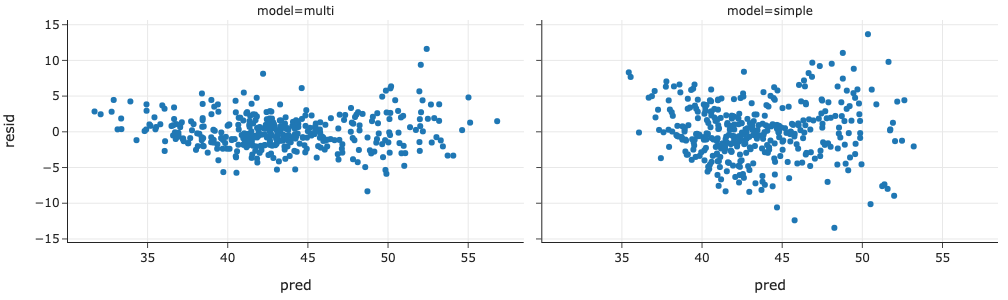

In [11]:
pred = predict(theta, X_train)
resid = y_train - pred

pred_simple = predict(theta_simple, X_train[['intr', 'frac_traveltime_lt15']])
resid_simple = y_train - pred_simple

all_resid = pd.concat([
    pd.DataFrame({'model': 'multi', 'pred': pred, 'resid': resid}),
    pd.DataFrame({'model': 'simple', 'pred': pred_simple, 'resid': resid_simple}),
], ignore_index=True)

fig = px.scatter(all_resid, x='pred', y='resid', facet_col='model',
                 width=550, height=300)
margin(fig, t=20)

We can see that the multiple linear model's residuals are much closer to 0
in general, which helps to explain why the MSE is also lower.

## Interpreting Linear Models

Now that we have a linear model, we want to know what it says about our data.
After fitting our simple linear model, we have:

$$
\begin{aligned}
f_{\theta}(x) = 31.1 + 29.3 x
\end{aligned}
$$

Here, $ x $ is the fraction of people with ≤15 min commute times.
We interpret this model as saying: if we take two commuting zones, and one of
them has 10% more people with a ≤15 min commute time, then the model predicts
that the AUM will be 2.93 points higher on average.
Simply put, commuting zones that have short commute times generally have
more economic mobility or opportunity.

We need to be careful about this interpretation.
It's tempting to say that increasing $ x $ by 0.1 *causes* or *is associated
with* an AUM that's 2.93 points higher.
But, our model doesn't let us make this conclusion.
Our model really only lets us draw conclusions about average differences
between commuting zones.
It doesn't let us draw conclusions about what would happen if we took a
single commuting zone and increased its $ x $.

We can try interpreting the the intercept term too.
We might say that the model predicts that commuting zones where $ x = 0 $ have
an average AUM of 31.1.
However, there aren't actually any data points in our data that have $ x = 0 $,
so this interpretation isn't useful.
In general, we have to check the meaning of the intercept on a case-by-case
basis.

Now, let's look at our multiple linear model.
Since our model has 9 predictor variables, we'll show the model coefficients in
a table rather than writing out the long model equation:

In [21]:
theta.index = ['intr', *predictors]
display_df(theta.rename('coeff').to_frame(), 10)

,coeff
intr,40.32
frac_traveltime_lt15,14.73
gini,-1.23
dropout_r,-36.60
rel_tot,5.86
cs_fam_wkidsinglemom,-43.89
taxrate,56.97
gradrate_r,0.51
frac_worked1416,440.29
cs_born_foreign,6.80


Let's look at the coefficient for `gradrate_r`, the college graduation rate.
For a multiple linear model, we interpret this coefficient as saying:
if we took two commuting zones that are the same in all predictors except 
`gradrate_r`, the model predicts that the commuting zone with a 0.1 larger
`gradrate_r` also has a 0.051 higher AUM.
The key difference for multiple linear models is that
we only have a useful interpretation for a coefficient when we can
hold the other predictors constant.

Unfortunately, this is not always the case.
As an extreme example, let's say our model happened to have an extra
predictor `2 * gradrate_r` which doubles each value from `gradrate_r`.
If our model had this predictor, it doesn't make sense to talk about
`gradrate_r`'s coefficient since we can't hold `2 * gradrate_r` constant.
In general, we need to watch out for *collinearity*, where two predictor
variables are highly correlated with each other.
If our model has variables with high collinearity, we can't make useful
interpretations for the model coefficients.

To check for collinearity, we can look at the correlations between each pair
of predictors, as shown in the heatmap below.

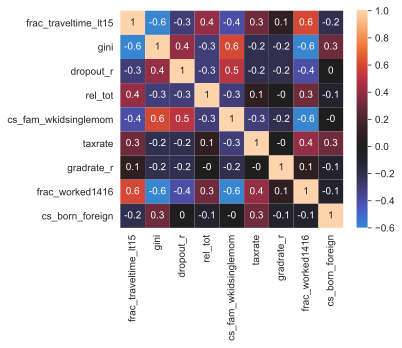

In [38]:
plt.figure(figsize=(5, 4))
sns.heatmap(df[predictors].corr().round(1), center=0, annot=True);

We see that `cs_fam_wkidsinglemom`, the fraction of families with a single mom,
has a high correlation with several other predictors, like `gini` and
`frac_worked1416`.
Here, we face a central tension in modeling.
If we want the most interpretable model, we should try to avoid collinearity.
For instance, we could remove variables that are highly correlated with others.
However, doing this often makes our model less accurate.
Having an interpretable model can mean having a less accurate model.
What's more important than the other? The answer is that it depends.
Each modeling situation needs a different tradeoff, and it's the
job of the data scientist to understand and make this tradeoff.

This section covered how to fit a multiple linear model using a geometric
perspective.
We then used our derivation to fit a multiple linear model on the 
economic opportunity data and found that it has a much better fit than
the simple linear model.
Finally, we interpreted our model coefficients and talked about how
it can be tricky to interpret multiple linear models.
In the next section, we'll introduce feature engineering techniques that 
make linear models useful for different kinds of data.